In [1]:
using Pkg
Pkg.status("JuMP")
Pkg.add("Clp")
Pkg.add("CSV")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("Mosek")
Pkg.add("MosekTools")
Pkg.add("LinearAlgebra")
Pkg.add("PyPlot")
Pkg.add("Ipopt")
# Pkg.add("NLopt")

using CSV
using DataFrames
using JuMP, Clp, Plots, Mosek, MosekTools
using Ipopt
using LinearAlgebra
using PyPlot
# using NLopt

      Status `C:\Users\thoug\.julia\environments\v1.7\Project.toml`
  [4076af6c] JuMP v0.22.3


    Updating registry at `C:\Users\thoug\.julia\registries\General.toml`
   Resolving package versions...
   Installed Qt5Base_jll ─ v5.15.3+1
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Project.toml`
    Updating `C:\Users\thoug\.julia\environments\v1.7\Manifest.toml`
  [ea2cea3b] ↑ Qt5Base_jll v5.15.3+0 ⇒ v5.15.3+1
Precompiling project...
  ✓ Qt5Base_jll
  ✓ GR_jll
  ✓ GR
  ✓ Plots
  4 dependencies successfully precompiled in 194 seconds (190 already precompiled, 1 skipped during auto due to previous errors)
   Resolving package versions...
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Project.toml`
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\thoug\.julia\environments\v1.7\Project.toml`
  No Changes to

LoadError: Error building `Mosek`: 
[ Info: Download command: `powershell -file 'C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\winget.ps1' https://www.mosek.com/downloads/default_dns.txt 'C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\downloads\downloadhostname'`
┌ Error: File C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\winget.ps1 cannot be loaded because running scripts is disabled 
│ on this system. For more information, see about_Execution_Policies at https:/go.microsoft.com/fwlink/?LinkID=135170.
│     + CategoryInfo          : SecurityError: (:) [], ParentContainsErrorRecordException
│     + FullyQualifiedErrorId : UnauthorizedAccess
└ @ Main C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\build.jl:203
ERROR: LoadError: Failed to get MOSEK download host
Stacktrace:
 [1] error(s::String)
   @ Base .\error.jl:33
 [2] top-level scope
   @ C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\build.jl:204
 [3] include(fname::String)
   @ Base.MainInclude .\client.jl:451
 [4] top-level scope
   @ none:5
in expression starting at C:\Users\thoug\.julia\packages\Mosek\au3Cq\deps\build.jl:144

### CS 524 Spring 2022

# Race Track Path Optimization

### Alex Vessel, Owen Thronson and Ryan Toh

## 1. Our Problem ##

### Overview ###

When a racing team is preparing for a race they want to know the optimal path that they will need to take since the entire sport can be decided by a few seconds. The teams will know what the paramaters of their car and the layout of the track for their race. Using these we will optimize the path that they should take to minimize their total time. 

### Why This Problem ? ###

This problem has complexity that leads to interesting results and has different analysis that can be preformed on it. 
The complexity of this problem is that there are trade offs that a car will have to make between a faster speed or a tighter turn since the car will be limited by its how fast it can turn at various speeds. The interesting part of this problem will be the ability to compare different teams' cars against eachother on the same track and compare the same car's path on different tracks.


## 2. Mathematical model ##

Our mathematical model minimizes the race time over a race track subject to staying within the track boundaries and the car's acceleration/velocity capabilities.  

**Decision Variables and Simple Constraints**

The decision variables are what the driver has control over - the $(x^i, y^i)$ position of their race line and their acceleration $a^i$ at each track segment $i$.  A track segment i is defined as a corresponding inner track boundary point $(x_{inner}^i, y_{inner}^i)$ and outer track boundary point $(x_{outer}^i, y_{outer}^i)$.  The entire course is made up of a collection of $N$ such discrete track segments.  The car must pass over the line connecting each of the $N$ track boundary pairs to complete the track.  This gives rise to the following constraint, derived from the equation of a line given two points: 

$$ (y^i  - y_{inner}^i) * (x_{outer}^i - x_{inner}^i) = (y_{outer}^i - y_{inner}^i) * (x^i - x_{inner}^i) \quad \forall i \in {1, 2,..., N}$$

Likewise, the model must be constrained to ensure the race line point lies between the track boundaries.  Define $w^i$ as the track width at track segment $i$.  This can be ensured by putting an upper bound on the distance of the race line to the track segment boundaries. This creates the additional constraints: 

$$ \sqrt{(x^i - x_{inner}^i)^2 + (y^i - y_{inner}^i)^2} \leq w^i  \quad \forall i \in {1, 2,..., N}$$
$$ \sqrt{(x^i - x_{outer}^i)^2 + (y^i - y_{outer}^i)^2} \leq w^i  \quad \forall i \in {1, 2,..., N}$$

Finally, the car is modeled with a maximum and minimum acceleration (minimum acceleration represents braking).

$$ a_{min} \leq a^i \leq a_{max} \quad \forall i \in {1, 2,..., N}$$

**Objective**

The objective is to minimize the race time over the track.  We model the car using simple Newtonian kinematics over the discretized race line points.  Assume, for now, the car is going some velocity $v^{i-1}$ at track segment $i-1$ (how this velocity is updated will be covered shortly).  The time to cover the distance from track segment $i-1$ to $i$ can be derived from the basic Newtonian kinematics equation and is defined as follows:

$$ t_{i-1}^{i} = \frac{-v^{i-1} + \sqrt{2 * d_{i-1}^{i} * a^{i-1} + {v^{i-1}}^2}}{a^{i-1}} $$

Where $d_{i-1}^{i}$ is the Euclidean distance from race line point $i-1$ to $i$.

The total time is then defined as the sum of these segment times across all segments:

$$ t_{total} = \Sigma_{i=1}^{N} t_{i-1}^{i} $$

**Velocity Constraint**

The velocity $v^i$ is constrained in three ways in our simple vehicle dynamics model:

1. Newtonian acceleration
2. Max car velocity
3. Turn radius velocity

The Newtonian acceleration constraint is the fastest the car's velocity can be given the acceleration and distance being covered:

$$ v_{accel}^{i} = \sqrt{{v^{i-1}}^2 + 2 * a^{i-1} * d_{i-1}^{i}} $$

The max car velocity is given as a parameter:

$$ v_{max} $$

The max turn radius velocity is defined as the maximum velocity the car can travel at a given turn radius without slipping.  This is given by the physical equation:

$$ v_{turn}^{i} = \sqrt{\mu * g * R^i} $$

where $\mu$ is the coefficient of friction between the ground and the tire.  Common values of $\mu$ range from 0.7 to 1.2.  The variable $g$ is the force of gravity, 9.8 m/s.  $R^i$ is the radius of the car's turn at race line point $i$.  This is calculated using a geometrical formula from 3 points:

$$ R^i = \frac{d_{i-1}^{i} * d_{i}^{i+1} * d_{i-1}^{i+1}}{4 * abs(A)}  $$

Where A is the area of the triangle defined by race line points $i-1, i, i+1$.

The velocity at a given race line point is then given as the minimum of these three velocities:

$$ v^i = \min{(v_{accel}^i, v_{max}, v_{turn}^i)} $$

This min function creates an interesting optimization problem - by taking tighter turns the vehicle travels less distance but must go slower, while by taking wider turns the vehicle can travel at a higher speed but must cover more distance.  The tradeoff between these factors generates interesting solutions where the optimal race line may require decelerating (braking) at certain points along the track.

**Complete Model**

Putting everything together, the complete model is given as follows:

$$
\begin{aligned}
\underset{x, y, a}{\text{minimize}}\qquad& \Sigma_{i=1}^{N} \frac{-v^{i-1} + \sqrt{2 * d_{i-1}^{i} * a^{i-1} + {v^{i-1}}^2}}{a^{i-1}} \\
\text{subject to:}\qquad& (y^i  - y_{inner}^i) * (x_{outer}^i - x_{inner}^i) = (y_{outer}^i - y_{inner}^i) * (x^i - x_{inner}^i) && \forall i \in {1, 2,..., N}\\
& \sqrt{(x^i - x_{inner}^i)^2 + (y^i - y_{inner}^i)^2} \leq w^i  && \forall i \in {1, 2,..., N}\\
& \sqrt{(x^i - x_{outer}^i)^2 + (y^i - y_{outer}^i)^2} \leq w^i  && \forall i \in {1, 2,..., N}\\
& a_{min} \leq a^i \leq a_{max} && \forall i \in {1, 2,..., N}\\
&  v^i = \min{(v_{accel}^i, v_{max}, v_{turn}^i)} && \forall i \in {1, 2,..., N}\\
\end{aligned}
$$

This problem is a second-order cone program.

## 3. Data ##

We will be using racetrack data provided by the Technical University of Munich (https://github.com/TUMFTM/racetrack-database) which contains track data for F1, DTM, and IndyCar.

The data is stored in .csv form and has the following format: [x_m, y_m, w_tr_right_m, w_tr_left_m] </br>
*x_m* and *y_m* refer to the center line (x, y) </br>
*w_tr_right_m* and *w_tr_left_m* refer to the track widths to the right and left

This is an issue because our model requires the co-ordinates of the inner and outer boundaries of the track.
We decided on using Python to parse the data due to the nature of the provided data and helper functions.

We utilized the calc_splines() function from the many helper functions also provided by TUM (https://github.com/TUMFTM/trajectory_planning_helpers/blob/master/trajectory_planning_helpers/calc_splines.py).</br>
And the math from a laptime simulation done by TUM (https://github.com/TUMFTM/laptime-simulation/blob/master/opt_raceline/src/plot_track.py) to calculate outer/inner points and to plot the track.

With the parsing done, we have the data we need for our model. </br>
Below are the Python code and sample plots for 2 F1 tracks: Austin and Budapest.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from calc_splines import calc_splines
import math

def calc_normal_vectors(track_imp_cl):
    el_lengths_imp_cl = np.sqrt(np.sum(np.power(np.diff(track_imp_cl[:, :2], axis=0), 2), axis=1))
    normvecs_normalized_imp = calc_splines(path=track_imp_cl[:, :2],
                                           el_lengths=el_lengths_imp_cl,
                                           use_dist_scaling=True)[3]
    normvecs_normalized_imp_cl = np.vstack((normvecs_normalized_imp, normvecs_normalized_imp[0]))
    return normvecs_normalized_imp_cl

def calc_outer_points(track_imp_cl, normvecs_normalized_imp_cl):
    return track_imp_cl[:, :2] + normvecs_normalized_imp_cl * np.expand_dims(track_imp_cl[:, 2], 1)

def calc_inner_points(track_imp_cl, normvecs_normalized_imp_cl):
    return track_imp_cl[:, :2] - normvecs_normalized_imp_cl * np.expand_dims(track_imp_cl[:, 3], 1)

def plot_track(outer_points, inner_points):
    fig = plt.figure(figsize=(12.0, 8.0))
    track = fig.add_subplot(111)

    track.plot(outer_points[:, 0], outer_points[:, 1], 'g-')
    track.plot(inner_points[:, 0], inner_points[:, 1], 'g-')

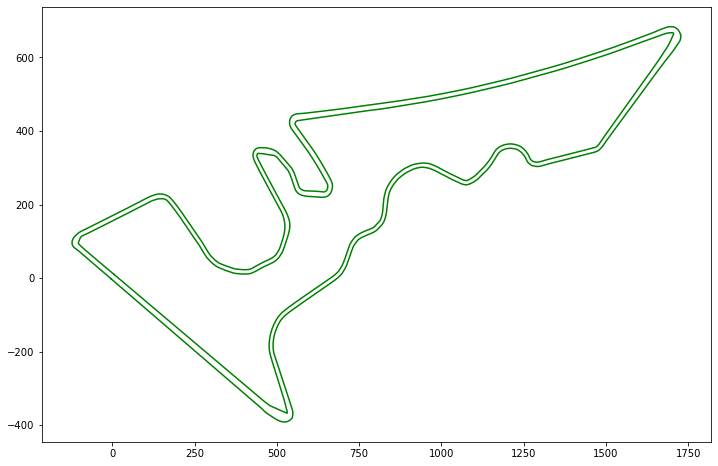

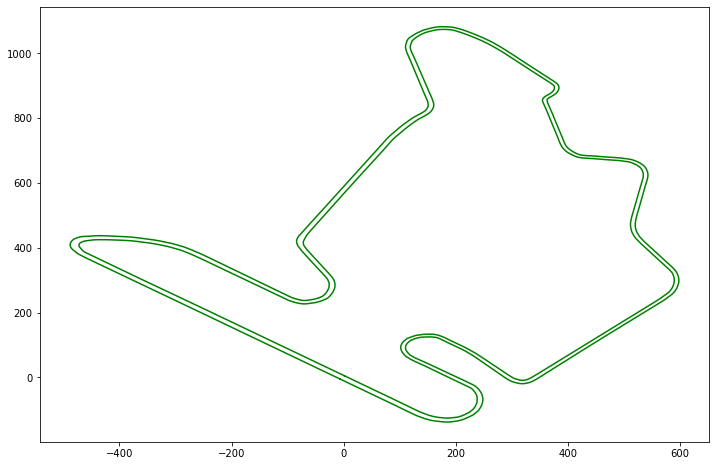

## 4. Solution ##

In [207]:
# Set parameters
outer_r = 100       # Radius of outer track circle
inner_r = 80        # Radius of inner track circle
amax = 11           # Maximum vehicle acceleration 
vmaxlin = 100       # Maximum vehicle linear velocity
mu = 0.7            # Coefficient of friction used in v_turn
delta = 1e-20       # Small constant to avoid dividing by 0 / taking d/dx sqrt(x) at 0
new_v = 0           # Starting velocity

# Generate circle track data for testing
outer = []
inner = []
for i in LinRange(0, 2*pi, 20)
    push!(outer, (outer_r * cos(i) + 100, outer_r * sin(i) + 100))
    push!(inner, (inner_r * cos(i) + 100, inner_r * sin(i) + 100))
end

# Create model using Ipopt optimizer
m = Model(with_optimizer(Ipopt.Optimizer, print_level=0, max_iter=10000))

# Create decision variables x, y, a
@variable(m, 0 <= x_path[1:length(outer)] <= 200)
@variable(m, 0 <= y_path[1:length(outer)] <= 200)
@variable(m, -3 <= a[1:length(outer)] <= amax)

# Set race line constraints to track
for i in 1:length(outer)
    # Ensure path coordinates lie in line with track boundaries
    @NLconstraint(m, (y_path[i] - inner[i][2]) * (outer[i][1] - inner[i][1]) == (outer[i][2] - inner[i][2]) * (x_path[i] - inner[i][1]))
    @NLconstraint(m, sqrt((x_path[i] - inner[i][1])^2 + (y_path[i] - inner[i][2])^2 + delta) <= 20)
    @NLconstraint(m, sqrt((x_path[i] - outer[i][1])^2 + (y_path[i] - outer[i][2])^2 + delta) <= 20)
end

t_total = @NLexpression(m, 0)

# Calculate total time
for i in 2:length(outer)-1
    # Calculate radius of path at point i
    d1 = @NLexpression(m, sqrt((x_path[i] - x_path[i-1])^2 + (y_path[i] - y_path[i-1])^2 + delta))
    d2 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i])^2 + (y_path[i+1] - y_path[i])^2 + delta))
    d3 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i-1])^2 + (y_path[i+1] - y_path[i-1])^2 + delta))
    area = @NLexpression(m, 0.5 * ((x_path[i] - x_path[i-1]) * (y_path[i+1] - y_path[i-1]) - (x_path[i+1] - x_path[i-1]) * (y_path[i] - y_path[i-1])))
    radius = @NLexpression(m, d1 * d2 * d3 / (4 * abs(area) + delta))

    # Update total time from current path segment
    t = @NLexpression(m, (-new_v + sqrt(2 * d1 * a[i-1] + new_v^2 + delta)) / (a[i-1] + delta))
    t_total = @NLexpression(m, t_total + t)

    # Find new velocity
    vmaxturn = @NLexpression(m, sqrt(mu * 9.8 * radius + delta))
    vmaxaccel = @NLexpression(m, sqrt(new_v^2 + 2 * a[i-1] * d1 + delta))

    new_v = @NLexpression(m, min(vmaxturn, vmaxaccel, vmaxlin))
end

# Optimize the model
@NLobjective( m, Min, t_total)

JuMP.optimize!(m)

println(termination_status(m))
println("Optimal time: ", objective_value(m))


LOCALLY_SOLVED
Optimal time: 18.562069309792545


┌ Warning: Function min automatically registered with 3 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :min, 3, min; autodiff = true)
│ ```
└ @ JuMP C:\Users\Alex Vesel\.julia\packages\JuMP\lnUbA\src\parse_nlp.jl:21


## 5. Results and discussion ##

To ensure the model functions as expected, the tradeoff between tighter/slower turns and wider/faster turns is compared.

**Starting the vehicle at 0 velocity**

When the vehicle starts at 0 velocity, we expect the car's velocity will be constrained by Newtonian acceleration as the car speeds up.  This implies that the model will prefer a shorter path (tighter turns) at the beginning of the track.  After a certain velocity, the car will be constrained by the turn radius velocity (this is typically lower than the car's maximum speed).  We expect the race line to straighten here, resulting in a wider turn.  The following model and plot show the optimal race line given a 0 velocity starting condition.

LOCALLY_SOLVED
Optimal time: 18.562069309792545


┌ Warning: Function min automatically registered with 3 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :min, 3, min; autodiff = true)
│ ```
└ @ JuMP C:\Users\Alex Vesel\.julia\packages\JuMP\lnUbA\src\parse_nlp.jl:21


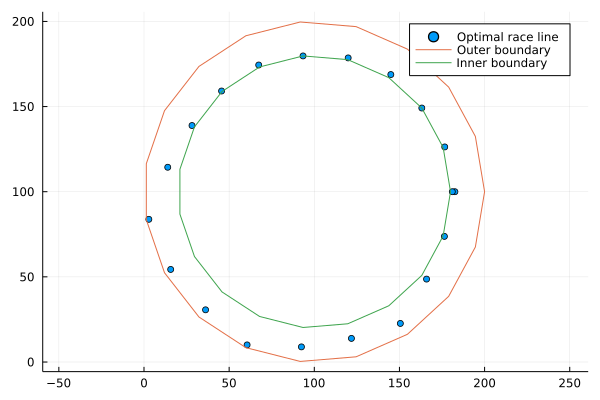

In [220]:
# Set parameters
outer_r = 100       # Radius of outer track circle
inner_r = 80        # Radius of inner track circle
amax = 11           # Maximum vehicle acceleration 
vmaxlin = 100       # Maximum vehicle linear velocity
mu = 0.7            # Coefficient of friction used in v_turn
delta = 1e-20       # Small constant to avoid dividing by 0 / taking d/dx sqrt(x) at 0
new_v = 0           # Starting velocity

# Generate circle track data for testing
outer = []
inner = []
for i in LinRange(0, 2*pi, 20)
    push!(outer, (outer_r * cos(i) + 100, outer_r * sin(i) + 100))
    push!(inner, (inner_r * cos(i) + 100, inner_r * sin(i) + 100))
end

# Create model using Ipopt optimizer
m = Model(with_optimizer(Ipopt.Optimizer, print_level=0, max_iter=10000))

# Create decision variables x, y, a
@variable(m, 0 <= x_path[1:length(outer)] <= 200)
@variable(m, 0 <= y_path[1:length(outer)] <= 200)
@variable(m, -3 <= a[1:length(outer)] <= amax)

# Set race line constraints to track
for i in 1:length(outer)
    # Ensure path coordinates lie in line with track boundaries
    @NLconstraint(m, (y_path[i] - inner[i][2]) * (outer[i][1] - inner[i][1]) == (outer[i][2] - inner[i][2]) * (x_path[i] - inner[i][1]))
    @NLconstraint(m, sqrt((x_path[i] - inner[i][1])^2 + (y_path[i] - inner[i][2])^2 + delta) <= 20)
    @NLconstraint(m, sqrt((x_path[i] - outer[i][1])^2 + (y_path[i] - outer[i][2])^2 + delta) <= 20)
end

t_total = @NLexpression(m, 0)

# Calculate total time
for i in 2:length(outer)-1
    # Calculate radius of path at point i
    d1 = @NLexpression(m, sqrt((x_path[i] - x_path[i-1])^2 + (y_path[i] - y_path[i-1])^2 + delta))
    d2 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i])^2 + (y_path[i+1] - y_path[i])^2 + delta))
    d3 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i-1])^2 + (y_path[i+1] - y_path[i-1])^2 + delta))
    area = @NLexpression(m, 0.5 * ((x_path[i] - x_path[i-1]) * (y_path[i+1] - y_path[i-1]) - (x_path[i+1] - x_path[i-1]) * (y_path[i] - y_path[i-1])))
    radius = @NLexpression(m, d1 * d2 * d3 / (4 * abs(area) + delta))

    # Update total time from current path segment
    t = @NLexpression(m, (-new_v + sqrt(2 * d1 * a[i-1] + new_v^2 + delta)) / (a[i-1] + delta))
    t_total = @NLexpression(m, t_total + t)

    # Find new velocity
    vmaxturn = @NLexpression(m, sqrt(mu * 9.8 * radius + delta))
    vmaxaccel = @NLexpression(m, sqrt(new_v^2 + 2 * a[i-1] * d1 + delta))

    new_v = @NLexpression(m, min(vmaxturn, vmaxaccel, vmaxlin))
end

# Optimize the model
@NLobjective( m, Min, t_total)

JuMP.optimize!(m)

println(termination_status(m))
println("Optimal time: ", objective_value(m))

Plots.scatter(value.(x_path), value.(y_path), aspect_ratio=:equal, label="Optimal race line")

Plots.plot!([x[1] for x in outer], [x[2] for x in outer], label="Outer boundary")
Plots.plot!([x[1] for x in inner], [x[2] for x in inner], label="Inner boundary")


From the above plot, the optimal race line calculated by the model is as expected.  Note: the race line begins at the middle right of the circle.  The above path shows one revolution around the track.

**Starting the vehicle at high velocity**

When the vehicle starts at high velocity, we expect the car's velocity will be immediately constrained by turn radius velocity.  This means the optimal race line should hover at some optimal turn radius somewhere between the track boundaries.  The following model implements a vehicle that starts at velocity=90, which is close to it's max speed of 100.  Note, units are relative in this context and do not represent real car physics yet.

LOCALLY_SOLVED
Optimal time: 18.892917313352957


┌ Warning: Function min automatically registered with 3 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :min, 3, min; autodiff = true)
│ ```
└ @ JuMP C:\Users\Alex Vesel\.julia\packages\JuMP\lnUbA\src\parse_nlp.jl:21


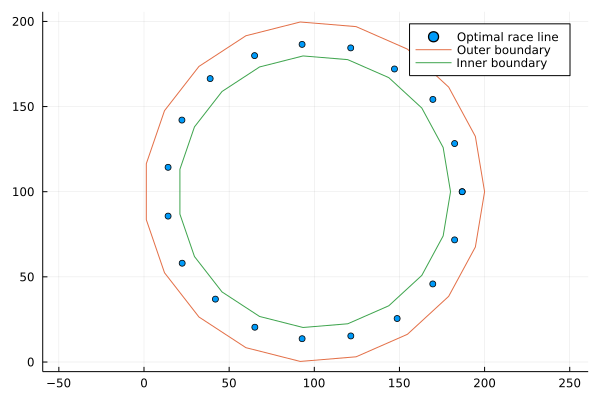

In [222]:
# Set parameters
outer_r = 100       # Radius of outer track circle
inner_r = 80        # Radius of inner track circle
amax = 11           # Maximum vehicle acceleration 
vmaxlin = 100       # Maximum vehicle linear velocity
mu = 0.7            # Coefficient of friction used in v_turn
delta = 1e-20       # Small constant to avoid dividing by 0 / taking d/dx sqrt(x) at 0
new_v = 90          # Starting velocity

# Generate circle track data for testing
outer = []
inner = []
for i in LinRange(0, 2*pi, 20)
    push!(outer, (outer_r * cos(i) + 100, outer_r * sin(i) + 100))
    push!(inner, (inner_r * cos(i) + 100, inner_r * sin(i) + 100))
end

# Create model using Ipopt optimizer
m = Model(with_optimizer(Ipopt.Optimizer, print_level=0, max_iter=10000))

# Create decision variables x, y, a
@variable(m, 0 <= x_path[1:length(outer)] <= 200)
@variable(m, 0 <= y_path[1:length(outer)] <= 200)
@variable(m, -3 <= a[1:length(outer)] <= amax)

# Set race line constraints to track
for i in 1:length(outer)
    # Ensure path coordinates lie in line with track boundaries
    @NLconstraint(m, (y_path[i] - inner[i][2]) * (outer[i][1] - inner[i][1]) == (outer[i][2] - inner[i][2]) * (x_path[i] - inner[i][1]))
    @NLconstraint(m, sqrt((x_path[i] - inner[i][1])^2 + (y_path[i] - inner[i][2])^2 + delta) <= 20)
    @NLconstraint(m, sqrt((x_path[i] - outer[i][1])^2 + (y_path[i] - outer[i][2])^2 + delta) <= 20)
end

t_total = @NLexpression(m, 0)

# Calculate total time
for i in 2:length(outer)-1
    # Calculate radius of path at point i
    d1 = @NLexpression(m, sqrt((x_path[i] - x_path[i-1])^2 + (y_path[i] - y_path[i-1])^2 + delta))
    d2 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i])^2 + (y_path[i+1] - y_path[i])^2 + delta))
    d3 = @NLexpression(m, sqrt((x_path[i+1] - x_path[i-1])^2 + (y_path[i+1] - y_path[i-1])^2 + delta))
    area = @NLexpression(m, 0.5 * ((x_path[i] - x_path[i-1]) * (y_path[i+1] - y_path[i-1]) - (x_path[i+1] - x_path[i-1]) * (y_path[i] - y_path[i-1])))
    radius = @NLexpression(m, d1 * d2 * d3 / (4 * abs(area) + delta))

    # Update total time from current path segment
    t = @NLexpression(m, (-new_v + sqrt(2 * d1 * a[i-1] + new_v^2 + delta)) / (a[i-1] + delta))
    t_total = @NLexpression(m, t_total + t)

    # Find new velocity
    vmaxturn = @NLexpression(m, sqrt(mu * 9.8 * radius + delta))
    vmaxaccel = @NLexpression(m, sqrt(new_v^2 + 2 * a[i-1] * d1 + delta))

    new_v = @NLexpression(m, min(vmaxturn, vmaxaccel, vmaxlin))
end

# Optimize the model
@NLobjective( m, Min, t_total)

JuMP.optimize!(m)

println(termination_status(m))
println("Optimal time: ", objective_value(m))

Plots.scatter(value.(x_path), value.(y_path), aspect_ratio=:equal, label="Optimal race line")

Plots.plot!([x[1] for x in outer], [x[2] for x in outer], label="Outer boundary")
Plots.plot!([x[1] for x in inner], [x[2] for x in inner], label="Inner boundary")


The model behaves as expected.

## 6. Planned analysis ##

We plan to run our optimization model on the real track boundaries.  We plan to define max acceleration and velocity values based on realistic values from F1 vehicles, and then perform analysis on how these parameters affect the optimal race line.